In [1]:
#CrossCompute

# Prompts users to enter a zipcode in the tool
# The default zipcode is 11419
target_folder = '/tmp'

ZipcodeInput = 11419

In [2]:
import subprocess
import sys

# This function is used to install packages using pip
# It's equivalent to doing 'pip install ______'
def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])

install('sodapy') # Package for NYC OpenData API
install('folium') # Package to generate map
install('Fiona')

In [3]:
import pandas as pd
from sodapy import Socrata # Used to access/ work with NYCOpenData API
import folium

In [4]:
#################################
# WORKING WITH CATCH BASIN DATA #
#################################


# Grabbing data from API
client = Socrata("data.cityofnewyork.us",
                'YFHnlAd1f74IprxACGOlr46td',
                username="nycopendataninjas@gmail.com",
                password="DataNinjas4TheWin!")

# Limits the data to only clogged catch basin complaints in a specified zipcode^
results = client.get("fhrw-4uyv", 
                     incident_zip = ZipcodeInput,
                     complaint_type="Sewer",
                     descriptor = "Catch Basin Clogged/Flooding (Use Comments) (SC)",
                     limit=10000)

# Convert to pandas DataFrame
df_threeOneOneReq = pd.DataFrame.from_records(results)

# Only gets the location of these complaints
complaintLoc = df_threeOneOneReq[['latitude','longitude']]

In [5]:
#################################
# WORKING WITH TREE CENSUS DATA #
#################################


# Limits the data to only trees that are ALIVE in that specified zipcode that was entered above^
results = client.get("5rq2-4hqu",
                     zipcode = ZipcodeInput,
                     status = 'Alive',
                     limit=10000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

# Only get the columns that are useful
results_df = results_df[['tree_dbh', 'health','status','latitude','longitude','spc_latin']]            
            
# Replaces words with numbers so that it is easier to create a 'grade' for each tree
results_df = results_df.replace(['Poor','Fair','Good'],[0,50,100])

# 'tree_dbh' was an object, this converts it to an int so that it can be added to 'health' and 'status'
results_df['tree_dbh'] = pd.to_numeric(results_df['tree_dbh'])

# Anywhere there is an 'NaN', make it a zero
results_df = results_df.fillna(0)

# Looks through list of each species and it's type
df = pd.read_csv('Species_Types.csv')
df = df.set_index('Species')

# Decides whether each tree is deciduous, conferous, etc.
results_df['Type'] = df.loc[results_df.spc_latin,'Type'].values

# Replaces words with numbers so that it is easier to create a 'grade' for each tree
results_df = results_df.replace(['deciduous','coniferous','evergreen','both'],[1,0,0,0])

# Generates a final grade that will be the value of the weight on the heat map for each tree
results_df['Final Grade'] = ((results_df.tree_dbh + results_df.health)/100)*results_df.Type

# Removes all the trees that dont lose leaves
results_df = results_df[results_df.Type != 0]
results_df = results_df.fillna(0)

In [6]:
# Only gets the location of these trees

treesLoc = results_df[['latitude', 'longitude']].copy()
treesLoc.dropna(subset=['latitude','longitude'], inplace=True)
treesList = [treesLoc]
treesList

[         latitude     longitude
 0     40.69199129  -73.82114902
 1     40.69161541  -73.82096547
 2     40.69153616  -73.82092678
 3     40.69210017  -73.82832551
 4     40.69166655    -73.829862
 5      40.6921299  -73.82821961
 6     40.69382431  -73.82753579
 7     40.69385554  -73.82742485
 8     40.69394083   -73.8271218
 9     40.69379328  -73.82764605
 10    40.68967489  -73.82221726
 11    40.69407543  -73.82728544
 12    40.69412078  -73.82707632
 13    40.69322963  -73.82436567
 14    40.69321395  -73.82441918
 15    40.69190202  -73.82110543
 16    40.69409821  -73.82718036
 17     40.6932463   -73.8243088
 18    40.69318198  -73.82452821
 19    40.69319875    -73.824471
 20    40.69316679  -73.82458003
 21     40.6935223  -73.82331912
 22    40.69313473   -73.8246894
 23    40.69388705   -73.8273129
 24    40.69404925  -73.82740613
 25    40.69427445  -73.82240225
 26    40.69031163  -73.83471829
 27    40.69315239  -73.83071821
 28    40.69282391  -73.83188216
 29    40.

In [7]:
df_threeOneOneReq_LOC = df_threeOneOneReq[['latitude', 'longitude']].copy()
df_threeOneOneReq_LOC.dropna(subset=['latitude','longitude'], inplace=True)

In [9]:
####################################
#   GETTING COMPLAINT COUNTS       #                            
#   WITHIN A 100 METER RADIUS      #
#         OF EACH TREE             #
####################################

import numpy as np
from pysal.cg.kdtree import KDTree
from pysal.cg import RADIUS_EARTH_MILES

complaints_xys = df_threeOneOneReq_LOC[['latitude', 'longitude']].astype(np.float).values 
complaints_tree = KDTree(complaints_xys, distance_metric='Arc', radius=RADIUS_EARTH_MILES)

ModuleNotFoundError: No module named 'pysal.cg'

In [10]:
complaints_count = len(complaints_xys)
complaints_count

618

In [11]:
xy = 40.682460735128025,-73.8300148272251
distances, indices = complaints_tree.query(xy, k=complaints_count, distance_upper_bound=0.5)

In [12]:
indices
indices[~np.isnan(indices)]
len(indices[~np.isnan(indices)])

314

In [13]:
# Setting radius equal to ~ 100 meters
radius_in_miles = 0.0497097

# Function that can find the number of complaints within 100 meters from each tree
def get_complaint_count(r):
    xy = r['latitude'], r['longitude']
    distances, indices = complaints_tree.query(xy, k=complaints_count, distance_upper_bound=radius_in_miles)
    indices = indices[~np.isnan(indices)]
    return len(indices)

# Applying functtion to each tree
treesLoc = treesLoc.apply(pd.to_numeric)
treesLoc['# of Complaints within 0.5 miles'] = treesLoc.apply(get_complaint_count,axis=1)

In [14]:
# Adding that column to the results_df
results_df['complaints'] = treesLoc['# of Complaints within 0.5 miles']

In [15]:
# This is what the final dataframe will look like
#results_df

In [16]:
# Used to print table in final tool result
# We most likely will not need it
# because we are using a map

from os.path import join
target_path = join(target_folder, 'results.csv')
results_df.to_csv(target_path, index=False)
print('result_table_path = %s' % target_path)

result_table_path = /tmp/results.csv


In [17]:
#################################
#     Generating a Heatmap      #
#################################


from folium import plugins
from folium.plugins import HeatMap

# Centers the map at the first coordinate in that zipcode
starting_Lat = results_df.iloc[0]['latitude']
starting_Long = results_df.iloc[0]['longitude']

# Coverts the starting points from string to float
starting_Lat = pd.to_numeric(starting_Lat, downcast='float')
starting_Long = pd.to_numeric(starting_Long, downcast='float')

# Creates the map centered at that point^, b/w, zoomed in
map_hooray = folium.Map(location=[starting_Lat, starting_Long],
                    tiles = "Stamen Toner",
                    zoom_start = 14.5)

# Ensure you're handing it floats
results_df['Latitude'] = results_df['latitude'].astype(float)
results_df['Longitude'] = results_df['longitude'].astype(float)
results_df['Final_Grade'] = results_df['Final Grade'].astype(float)

results_df = results_df.fillna(0)

# This is what we will be putting onto the map: Latitude, longitude, and a "weight"
heat_data = [[row['Latitude'],row['Longitude'],row['Final Grade']] for index, row in results_df.iterrows()]

# Plot it on the map
HeatMap(heat_data, 
        min_opacity = 0.01, 
        max_val = 1.5, 
        blur = 20, 
       ).add_to(map_hooray)

# Allows the map to go fullscreen
folium.plugins.Fullscreen(position='topright',
                          title='Full Screen',
                          title_cancel='Exit Full Screen',
                          force_separate_button=True
                         ).add_to(map_hooray)

# Display the map
map_hooray

In [18]:
#################################
#       Training a Model        #
#################################


In [19]:
x = results_df[[
    'tree_dbh',
    'health',
    'Type'
]]
y = results_df['complaints']

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [21]:
cross_val_score(model1, x,y,cv=3,scoring = 'neg_mean_absolute_error')

array([-6.66012407, -6.79546739, -5.40887688])

In [22]:
q = [19,50,1]
model1.predict([q])

array([11.25671526])

In [23]:
from sklearn.linear_model import BayesianRidge
model2 = BayesianRidge()
model2.fit(x,y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [24]:
cross_val_score(model2, x,y,cv=3,scoring = 'neg_mean_absolute_error').mean()

-6.285259013190195

In [25]:
model2.predict([q])

array([11.17912212])

In [26]:
import os
import webbrowser
map_hooray.save('map.html')

In [27]:
'''
import os
import subprocess
outdir = "Screenshots"
map_hooray.save("map.html")
url = "file://map.html".format(os.getcwd())
outfn = os.path.join(outdir,"outfig.png")
subprocess.check_call(["cutycapt","--url={}".format(url), "--out={}".format(outfn)])
'''
# WIP
# Code to save map as a pgn to be accessible on CrossCompute

'\nimport os\nimport subprocess\noutdir = "Screenshots"\nmap_hooray.save("map.html")\nurl = "file://map.html".format(os.getcwd())\noutfn = os.path.join(outdir,"outfig.png")\nsubprocess.check_call(["cutycapt","--url={}".format(url), "--out={}".format(outfn)])\n'

In [28]:
%matplotlib inline
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
 

In [29]:
treesLoc

,latitude,longitude,# of Complaints within 0.5 miles
0,40.691991,-73.821149,10
1,40.691615,-73.820965,7
2,40.691536,-73.820927,7
3,40.692100,-73.828326,8
4,40.691667,-73.829862,11
5,40.692130,-73.828220,8
6,40.693824,-73.827536,4
7,40.693856,-73.827425,2
8,40.693941,-73.827122,2
9,40.693793,-73.827646,4


In [30]:
from shapely.geometry import Point
lls = treesLoc[['longitude', 'latitude']].values
ll_points = [Point(_) for _ in lls]

In [31]:
target_proj4 = (
    '+proj=lcc +lat_1=41.03333333333333 +lat_2=40.66666666666666 '
    '+lat_0=40.16666666666666 +lon_0=-74 +x_0=300000.0000000001 +y_0=0 +ellps=GRS80 ' 
    '+datum=NAD83 +to_meter=0.3048006096012192 +no_defs ')

In [32]:
from geotable.projections import get_transform_shapely_geometry, LONGITUDE_LATITUDE_PROJ4
transform_shapely_geometry = get_transform_shapely_geometry(LONGITUDE_LATITUDE_PROJ4, target_proj4)

In [33]:
xy_points = [transform_shapely_geometry(g) for g in ll_points]

In [34]:
xys = [[_.x, _.y] for _ in xy_points]
xys

[[1033847.8707557486, 191438.16226065008],
 [1033899.0515508064, 191301.32240691432],
 [1033909.8398974979, 191272.4712977005],
 [1031857.6548645254, 191473.84853362272],
 [1031431.8728140886, 191315.03701283535],
 [1031887.001086411, 191484.73759774523],
 [1032075.417874307, 192102.43241733414],
 [1032106.1597834653, 192113.87099342345],
 [1032190.1359940091, 192145.1103000095],
 [1032044.8643610342, 192091.06711697386],
 [1033553.3461153246, 190593.62853743866],
 [1032144.6610346106, 192194.0594357817],
 [1032202.6184250781, 192210.69615250683],
 [1032954.9454699566, 191887.52011803782],
 [1032940.1181464486, 191881.777696558],
 [1033860.0252749054, 191405.66332976424],
 [1032173.783862781, 192202.41631585],
 [1032970.7038191559, 191893.62510275698],
 [1032909.9065332928, 191870.06952374193],
 [1032925.7591169882, 191876.21110100677],
 [1032895.5474827107, 191864.50658935402],
 [1033244.9475374835, 191994.73182205242],
 [1032865.2416072892, 191852.7654937561],
 [1032137.1815413903, 1

In [35]:
import numpy as np
xy_array = np.array(xys)

In [36]:
xs = xy_array[:, 0] 
ys = xy_array[:, 1]

xs

array([1033847.87075575, 1033899.05155081, 1033909.8398975 , ...,
       1030956.18275112, 1031061.0567902 , 1030852.47589388])

In [37]:
ys

array([191438.16226065, 191301.32240691, 191272.4712977 , ...,
       190135.99126526, 190175.30029261, 190951.07139433])

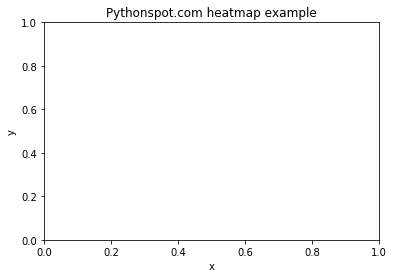

In [38]:
#Create heatmap
heatmap, xedges, yedges = np.histogram2d(xs, ys, bins=(64,64))
extent = [xedges[1], xedges[-1], yedges[1], yedges[-1]]
 
# Plot heatmap
plt.clf()
plt.title('Pythonspot.com heatmap example')
plt.ylabel('y')
plt.xlabel('x')

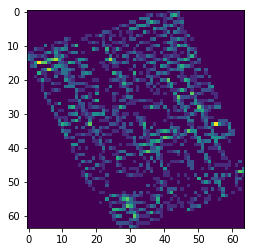

In [39]:
plt.imshow(heatmap, extent=extent)
plt.imshow(heatmap)

plt.show()

In [40]:
xys = np.array(xys)

In [41]:
filtered_xys = xys[(xys[:,0] > 1) & (xys[:,1] > 1)]
xs = filtered_xys[:, 0] 
ys = filtered_xys[:, 1]

xs

array([1033847.87075575, 1033899.05155081, 1033909.8398975 , ...,
       1030956.18275112, 1031061.0567902 , 1030852.47589388])

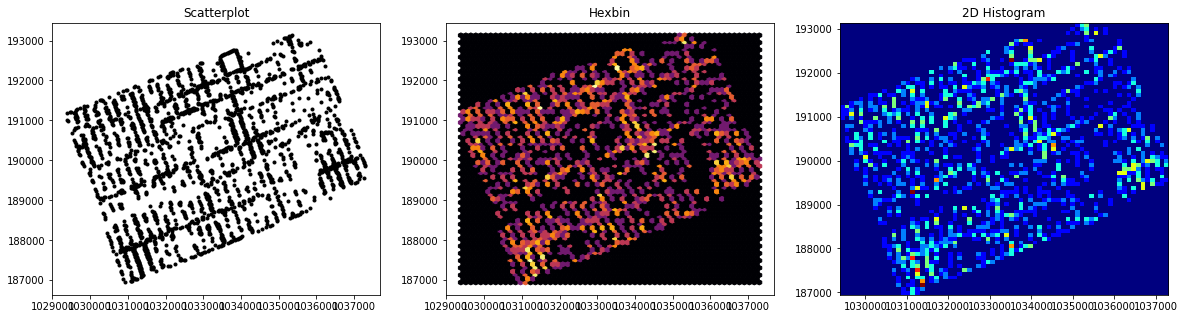

In [42]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
 
# Create data: 200 points
#data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 3]], 200)
#x, y = data.T
x = xs
y = ys

# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 5)) #og 21,5

# Everything sarts with a Scatterplot
axes[0].set_title('Scatterplot')
axes[0].plot(x, y, 'ko', markersize=3)
# As you can see there is a lot of overplottin here!
 
# Thus we can cut the plotting window in several hexbins
nbins = 70
axes[1].set_title('Hexbin')
axes[1].hexbin(x, y, gridsize=60,bins='log', cmap='inferno')
 
# 2D Histogram

axes[2].set_title('2D Histogram')
axes[2].hist2d(x, y, bins=nbins, cmap='jet')
plt.show()


In [43]:
#save by doing targetpath
# Save file to target folder to include it in the result download
target_path = target_folder + '/Businesses.png'
#figure = axes.get_figure()

fig.savefig(target_path)
print(f'Businesses_image_path = {target_path}')
#print('a_image_path = %s' % target_path)

Businesses_image_path = /tmp/Businesses.png


In [44]:
blocks = client.get("twhy-dzjp",
                    boro_code = 2,
                     limit=10000)

# Convert to pandas DataFrame
blocksDF = pd.DataFrame.from_records(blocks)

from geotable import GeoTable

# Link for the 2010 Census BLOCKS shapefile data
t = GeoTable.load("2010 Census Blocks.zip")

t

,bctcb2010,boro_code,boro_name,cb2010,ct2010,shape_area,shape_leng,geometry_object,geometry_layer,geometry_proj4
0,50009001000,5,Staten Island,1000,000900,2.445896e+05,2508.948115,POLYGON ((-74.07920577013245 40.64343078374567...,geo_export_7753596b-be5c-4ff9-a64c-ddfbaf0c5d08,+proj=longlat +ellps=WGS84 +no_defs
1,50020011000,5,Staten Island,1000,002001,1.110063e+05,1345.886422,POLYGON ((-74.07061992438017 40.61085506705416...,geo_export_7753596b-be5c-4ff9-a64c-ddfbaf0c5d08,+proj=longlat +ellps=WGS84 +no_defs
2,50027001000,5,Staten Island,1000,002700,1.504068e+05,1703.381172,POLYGON ((-74.07524403910642 40.62600632452712...,geo_export_7753596b-be5c-4ff9-a64c-ddfbaf0c5d08,+proj=longlat +ellps=WGS84 +no_defs
3,50040001000,5,Staten Island,1000,004000,1.412966e+05,1511.173743,POLYGON ((-74.08708799689826 40.61116883123925...,geo_export_7753596b-be5c-4ff9-a64c-ddfbaf0c5d08,+proj=longlat +ellps=WGS84 +no_defs
4,50064001000,5,Staten Island,1000,006400,2.007850e+05,1978.243852,POLYGON ((-74.07643744511992 40.60100160655585...,geo_export_7753596b-be5c-4ff9-a64c-ddfbaf0c5d08,+proj=longlat +ellps=WGS84 +no_defs
5,50074001000,5,Staten Island,1000,007400,1.390840e+05,1540.875503,POLYGON ((-74.06589403843647 40.59682603642131...,geo_export_7753596b-be5c-4ff9-a64c-ddfbaf0c5d08,+proj=longlat +ellps=WGS84 +no_defs
6,50075001000,5,Staten Island,1000,007500,1.235605e+05,1412.642887,POLYGON ((-74.08568983334587 40.63660727984283...,geo_export_7753596b-be5c-4ff9-a64c-ddfbaf0c5d08,+proj=longlat +ellps=WGS84 +no_defs
7,50077001000,5,Staten Island,1000,007700,2.057710e+05,2421.037307,POLYGON ((-74.08709163679771 40.64033437636213...,geo_export_7753596b-be5c-4ff9-a64c-ddfbaf0c5d08,+proj=longlat +ellps=WGS84 +no_defs
8,50112011000,5,Staten Island,1000,011201,1.961123e+05,1943.029020,"POLYGON ((-74.0865414171051 40.58373352623683,...",geo_export_7753596b-be5c-4ff9-a64c-ddfbaf0c5d08,+proj=longlat +ellps=WGS84 +no_defs
9,50112021000,5,Staten Island,1000,011202,9.273776e+04,1233.682178,POLYGON ((-74.09940090442285 40.57918675553432...,geo_export_7753596b-be5c-4ff9-a64c-ddfbaf0c5d08,+proj=longlat +ellps=WGS84 +no_defs


In [45]:
target_path = t.save_csv(target_folder + '/choropleth.csv')
print('borough_choropleth_geotable_path = %s' % target_path)


borough_choropleth_geotable_path = /tmp/choropleth.csv
